# Notebook 2 : Analyse NLP des résumés de films (`overviews`)

Cette section développe un système de recommandation de films fondé sur l'analyse de la similarité textuelle. Nous exploitons ici les **overviews** (résumés des films), une donnée qui n'avait pas été intégrée dans le modèle précédent du notebook 1.   

L'objectif est de trouver des films dont les thématiques sont proches en analysant le contenu sémantique de leurs résumés.

4 étapes :

- **1). Chargement et nettoyage des données** : sélection des variables pertinentes (*overview*, *genres*, *director*, *popularity*).
- **2). Prétraitement NLP** : nettoyage complet des textes à l'aide de la bibliothèque `SpaCy` (lemmatisation, suppression des mots vides).
- **3). Analyse textuelle et nuages de mots** : exploration des mots les plus fréquents via des nuages de mots (`Wordclouds`) par genre et par réalisateur.
- **4). Modélisation et recommandation** : calcul de similarité sémantique pour générer des recommandations.


## 1). Chargement et nettoyage des données

Dans cette première phase, nous importons les bibliothèques nécessaires et préparons notre jeu de données issu de la jointure entre **IMDB** et **TMDB**.

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud
!pip install pandas pyarrow
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.3 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests
import gdown

from wordcloud import WordCloud
import spacy

from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load data 
file_path = "/home/onyxia/work/projet_python_films/Data processing/data_IMDB_TMDB_join.parquet"
df = pd.read_parquet(file_path)

#### Le nettoyage consiste à :

- Conserver uniquement les colonnes essentielles pour l'analyse.
- Renommer les colonnes pour plus de clarté.
- Gérer les valeurs manquantes dans les descriptions.
- Transformer la chaîne de caractères des genres en liste Python.

In [4]:
# Nettoyage du df 
def clean_df(df):
    cols_to_keep = ['originalTitle', 'genres', 'overview', 'director_name', 'popularity_TMDB']
    df_cleaned = df[cols_to_keep].copy()
    df_cleaned = df_cleaned.rename(columns={'originalTitle': 'title', 'popularity_TMDB': 'popularity'})
    df_cleaned = df_cleaned.rename(columns={'director_name': 'director'})
    df_cleaned['genres'] = df_cleaned['genres'].fillna('').apply(lambda x: x.split(',') if x != '' else [])
    df_cleaned = df_cleaned.dropna(subset=['overview'])
    
    return df_cleaned


df_overviews = clean_df(df)
df_overviews.head()

,title,genres,overview,director,popularity
0,Miss Jerry,[Romance],The adventures of a female reporter in the 1890s.,Alexander Black,0.2544
1,The Corbett-Fitzsimmons Fight,"[Documentary, News, Sport]","This legendary fight was filmed on March 17, 1...",Enoch J. Rector,0.0511
2,The Story of the Kelly Gang,"[Action, Adventure, Biography]",Just as Galeen and Wegener's Der Golem (1915) ...,Charles Tait,0.1518
3,L'enfant prodigue,[Drama],The first feature-length motion picture produc...,Michel Carré,0.0632
4,The Life of Moses,"[Biography, Drama, Family]",Released in five parts (The Persecution of the...,J. Stuart Blackton,0.9570


## 2). Pré-processing NLP

Le texte brut contient beaucoup de **bruit** (ponctuation, mots de liaison comme *"the"*, *"and"*, *"is"*, etc.) qui n'apporte pas de valeur sémantique.  
Nous utilisons `SpaCy` pour standardiser les résumés.

#### Étapes du traitement :

- **Mise en minuscule** : uniformisation du texte.
- **Lemmatisation** : réduction des mots à leur racine (ex. *"running"* → *"run"*).
- **Suppression des stop-words** : retrait des mots fréquents sans importance sémantique.
- **Retrait de la ponctuation**.

> **Note importante**  
> Le traitement complet sur plus de **230 000 lignes** prenant environ **20 minutes**, nous utilisons une version pré-enregistrée du DataFrame  
> (**`movies_nlp_ready.parquet`**) contenant la colonne déjà nettoyée : **`clean_overviews`**.

Cette approche garantit la **reproductibilité du projet** tout en évitant des temps de calcul excessifs lors de l'évaluation.


In [5]:
# Minuscules, lemmatisation, retrait stop-words/ponctuation
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def preprocess_nlp(text):
    # Traitement par spacy : mise en minuscule et lemmatisation
    doc = nlp(text.lower())
    # On retire la ponctuation et les stop-words
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

Nous allons télécharger directement le fichier parquet contenant `overview_clean` qui a été déposé sur le drive, car la transformation avec `SpaCy` prend autour de 20 minutes. Vous pouvez néanmoins voir le code qui a été implémenté pour obtenir la colonne `overview_clean` ci-dessous. 

In [6]:
DRIVE_FILE_ID = '1fLcsAi0oAKFCjaLTgwpssCX9yg4QfYpP'
LOCAL_FILE = 'movies_nlp_ready.parquet'

In [7]:
def load_data(df_raw=None, text_column="overview"):

    # Tentative chargement local
    if os.path.exists(LOCAL_FILE):
        print("📂 Chargement du fichier local...")
        return pd.read_parquet(LOCAL_FILE)

    # Tentative téléchargement depuis Google Drive
    try:
        print("☁️ Téléchargement depuis Google Drive...")
        url = f"https://drive.google.com/uc?id={DRIVE_FILE_ID}"
        gdown.download(url, LOCAL_FILE, quiet=False)

        if os.path.exists(LOCAL_FILE):
            return pd.read_parquet(LOCAL_FILE)

    except Exception as e:
        print("⚠️ Échec du téléchargement Drive :", e)

    # Preprocessing from scratch
    if df_raw is None:
        raise ValueError(
            "Aucune donnée disponible : "
            "df_raw est requis pour refaire le preprocessing."
        )

    print("🧠 Preprocessing NLP en cours (long)...")

    df = df_raw.copy()
    df["overview_clean"] = df[text_column].apply(preprocess_nlp)

    # Sauvegarde pour les prochains runs
    df.to_parquet(LOCAL_FILE)
    print("💾 Fichier sauvegardé en local.")

    return df

In [8]:
df_overviews = load_data(df_overviews)
df_overviews.head()

☁️ Téléchargement depuis Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1fLcsAi0oAKFCjaLTgwpssCX9yg4QfYpP
To: /home/onyxia/work/projet_python_films/Data processing/movies_nlp_ready.parquet
100%|██████████| 84.0M/84.0M [00:00<00:00, 87.0MB/s]


,title,genres,overview,director,popularity,overview_clean
0,Miss Jerry,[Romance],The adventures of a female reporter in the 1890s.,Alexander Black,0.2544,adventure female reporter 1890s
1,The Corbett-Fitzsimmons Fight,"[Documentary, News, Sport]","This legendary fight was filmed on March 17, 1...",Enoch J. Rector,0.0511,legendary fight film march 17 1897 63 mm film ...
2,The Story of the Kelly Gang,"[Action, Adventure, Biography]",Just as Galeen and Wegener's Der Golem (1915) ...,Charles Tait,0.1518,galeen wegener der golem 1915 see testament ...
3,L'enfant prodigue,[Drama],The first feature-length motion picture produc...,Michel Carré,0.0632,feature length motion picture produce europe r...
4,The Life of Moses,"[Biography, Drama, Family]",Released in five parts (The Persecution of the...,J. Stuart Blackton,0.9570,release part persecution child israel egyptian...


## 3). Analyse textuelle et Nuages de mots

Nous avons créé des fonctions pour générer des **Wordclouds** avec un style visuel inspiré de l'univers cinématographique.

Ces visualisations permettent d'identifier rapidement les termes dominants associés à :

- un **genre cinématographique** donné,
- l'**univers d'un réalisateur**.

#### Exemples de fonctions développées :

- **`show_director_cloud`** : affiche les mots-clés dominants dans la filmographie d'un cinéaste.
- **`show_genre_cloud`** : identifie les thématiques fortes associées à un genre spécifique (ex. *action*, *romance*).


In [9]:
# Creating Wordclouds 

def plot_wordcloud(text, title, color_map="YlOrRd"):
    """Génère un nuage de mots avec un style cinéma"""
    # Pour un style "cinéma", on utilise un fond noir et des couleurs chaudes
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='black',
        font_path='/home/onyxia/work/projet_python_films/Data processing/BebasNeue-Regular.ttf', 
        colormap=color_map,
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20, color='white', backgroundcolor='black')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


def show_director_cloud(df, director_name):
    """Affiche le nuage de mots pour un réalisateur spécifique"""
    director_movies = df[df['director'] == director_name]
    if director_movies.empty:
        print(f"Réalisateur '{director_name}' non trouvé.")
        return
    
    text = " ".join(director_movies['overview_clean'])
    plot_wordcloud(text, f"Univers Visuel : {director_name}", "Blues")

def show_genre_cloud(df, genre_name):
    """Affiche le nuage de mots pour un genre spécifique"""
    # On filtre les films qui contiennent le genre dans leur liste
    genre_movies = df[df['genres'].apply(lambda x: genre_name in x)]
    text = " ".join(genre_movies['overview_clean'])
    plot_wordcloud(text, f"Thématiques du genre : {genre_name}", "magma")

### Quelques exemples

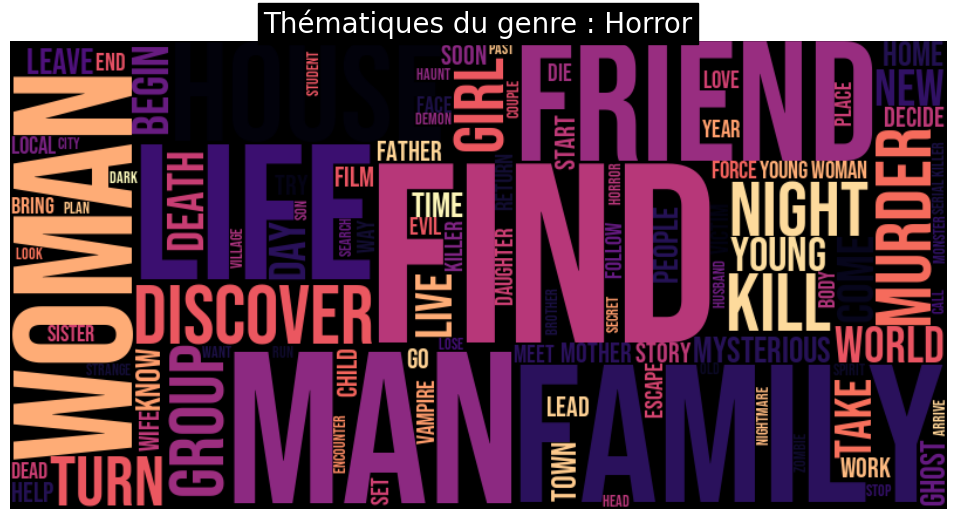

In [10]:
show_genre_cloud(df_overviews, "Horror")

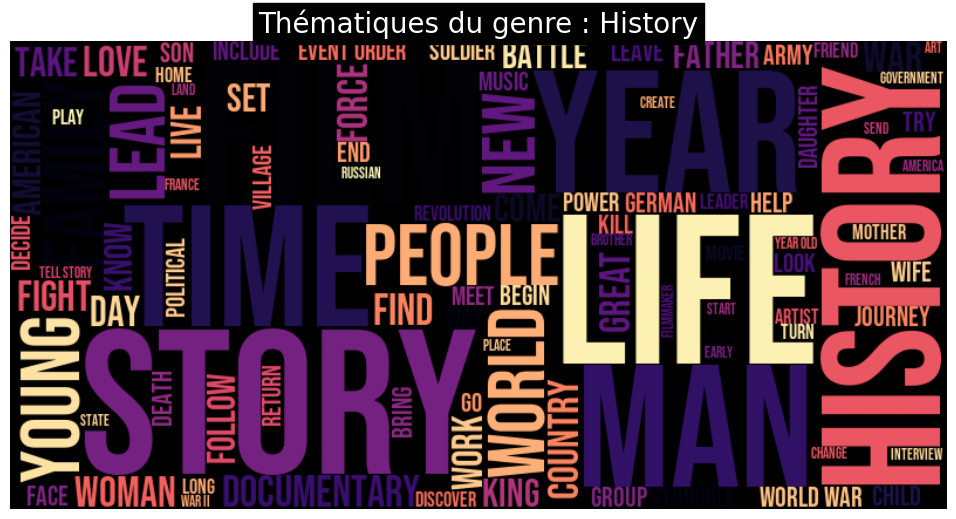

In [11]:
show_genre_cloud(df_overviews, "History")

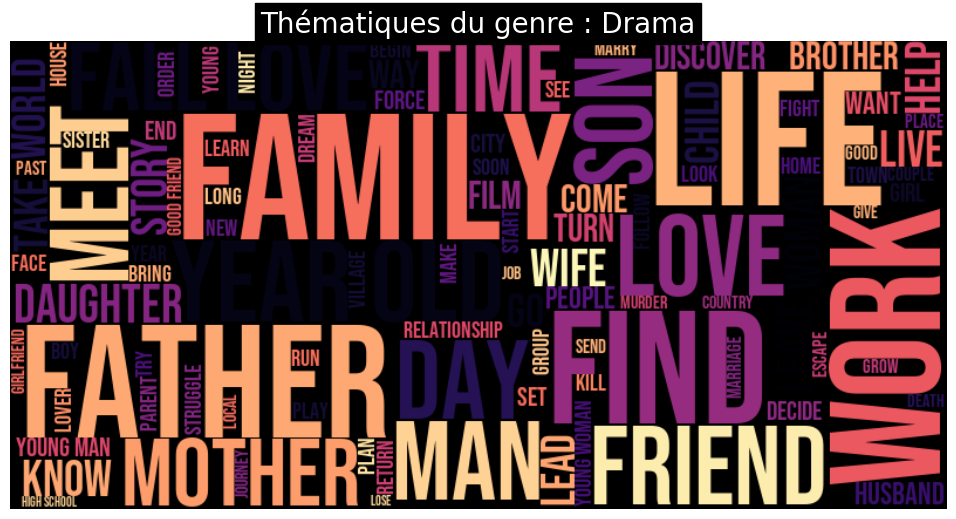

In [12]:
show_genre_cloud(df_overviews, "Drama")

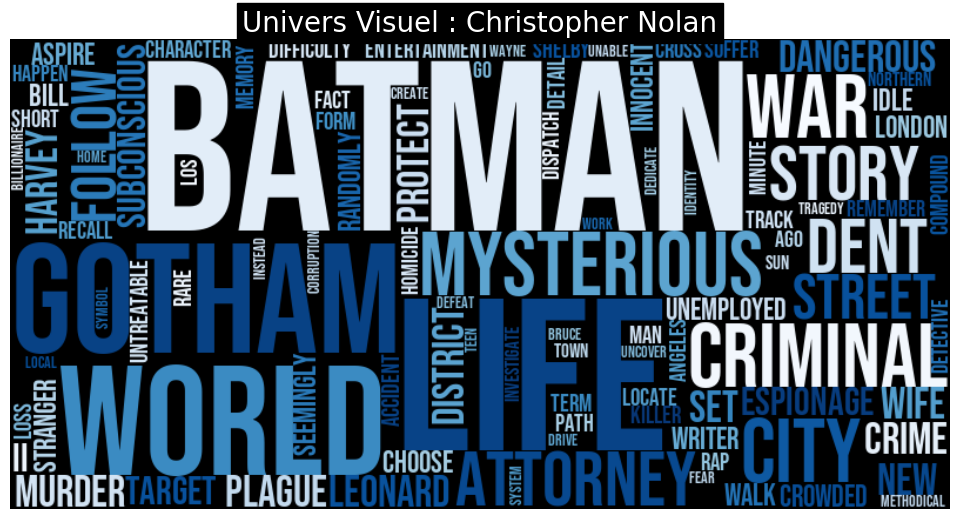

In [13]:
show_director_cloud(df_overviews, "Christopher Nolan")

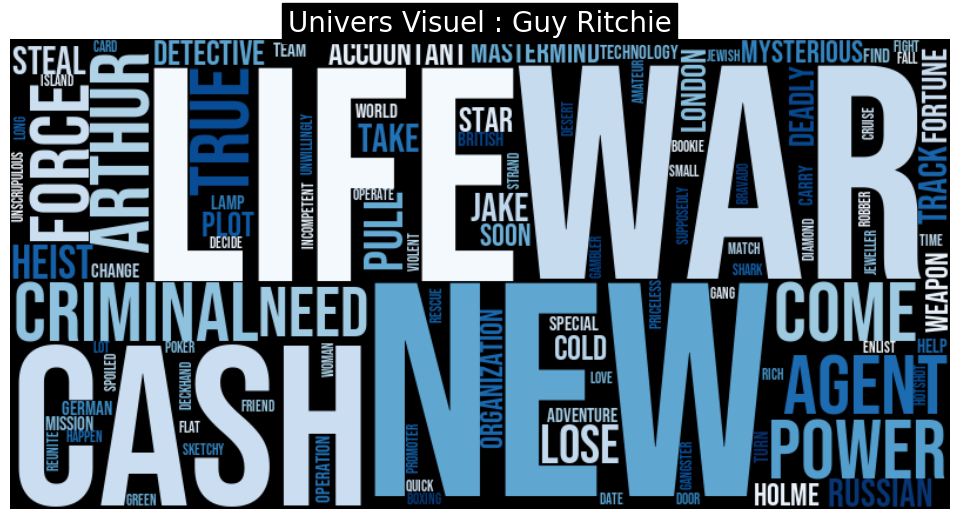

In [14]:
show_director_cloud(df_overviews, "Guy Ritchie")

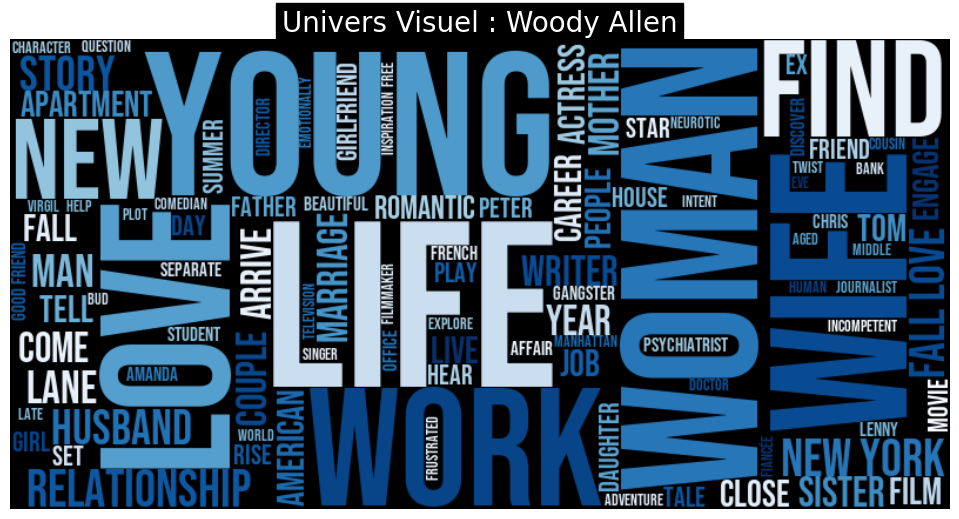

In [15]:
show_director_cloud(df_overviews, "Woody Allen")

## 4). Modélisation : Cosine Similarity

Dans cette section, nous allons directement implementer la méthode basée sur Sentence transformers, car l'approche de bag of words n'a pas donné des bons résultats. En effet, les recommendations étaient basées sur la recherche exacte des mêmes mots sans s'intéresser à leur signification sémantique.  

In [16]:
!pip install -U sentence-transformers

In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


De la même manière, ici, nous allons télécharger un fichier parquet déjà enregistré sur google drive, afin d'éviter un temps d'attente (presque 1h). 

#### Feature Engineering 

In [18]:
# Normaliser la popularity 

# On utilise log1p pour éviter les erreurs si la popularité est à 0
df_overviews['pop_log'] = np.log1p(df_overviews['popularity'])

# On normalise entre 0 et 1
scaler = MinMaxScaler()
df_overviews['popularity_norm'] = scaler.fit_transform(df_overviews[['pop_log']])
df_overviews = df_overviews.drop(columns=['pop_log'])

print("Normalisation terminée. Top 5 des films les plus 'populaires' (score 0 à 1) :")
print(df_overviews[['title', 'popularity_norm']].sort_values(by='popularity_norm', ascending=False).head())

Normalisation terminée. Top 5 des films les plus 'populaires' (score 0 à 1) :
                                title  popularity_norm
246696                     Tron: Ares         1.000000
201133                        Troll 2         0.997378
193235  Kantara: A Legend - Chapter 1         0.940750
206715           Dracula: A Love Tale         0.900808
218448                        Wildcat         0.894874


In [19]:
df_overviews['genres_str'] = df_overviews['genres'].apply(lambda x: ' '.join(x))

# On crée la soupe en combinant le résumé + les genres + le réalisateur 
df_overviews['soup'] = (
    df_overviews['genres_str'] + ' ' + 
    df_overviews['director'].fillna('') + ' ' + 
    df_overviews['overview_clean'].fillna('')
)

In [20]:
# À définir plus tard quand tu auras uploadé sur Drive
DRIVE_EMBEDDINGS_ID = '1zlMsOV1sVscD5p909FWwGDMqWY7eMJPG' 
LOCAL_EMBEDDINGS_FILE = "movie_embeddings.npy"


def load_or_compute_embeddings(
    df,
    text_column="soup",
    local_file=LOCAL_EMBEDDINGS_FILE,
    drive_file_id=DRIVE_EMBEDDINGS_ID,
    model_name="all-MiniLM-L6-v2"
):
    """
    Charge ou calcule les embeddings sémantiques des films.

    Ordre de priorité :
    1) Chargement local
    2) Téléchargement Google Drive
    3) Calcul from scratch (long)

    Returns
    -------
    np.ndarray
        Matrice d'embeddings
    """

    # 1️⃣ Chargement local
    if os.path.exists(local_file):
        print("📂 Chargement des embeddings depuis le fichier local...")
        return np.load(local_file)

    # 2️⃣ Téléchargement Drive
    if drive_file_id is not None:
        try:
            print("☁️ Téléchargement des embeddings depuis Google Drive...")
            url = f"https://drive.google.com/uc?id={drive_file_id}"
            gdown.download(url, local_file, quiet=False)

            if os.path.exists(local_file):
                return np.load(local_file)

        except Exception as e:
            print("⚠️ Échec du téléchargement Drive :", e)

    # 3️⃣ Calcul des embeddings (long)
    print("🧠 Calcul des embeddings sémantiques (opération longue)...")

    model = SentenceTransformer(model_name)
    embeddings = model.encode(
        df[text_column].fillna("").tolist(),
        show_progress_bar=True
    )

    # Sauvegarde pour les prochains runs
    np.save(local_file, embeddings)
    print("💾 Embeddings sauvegardés en local.")

    return embeddings

In [21]:
embeddings = load_or_compute_embeddings(
    df_overviews,
    text_column="soup",
    local_file=LOCAL_EMBEDDINGS_FILE,
    drive_file_id=DRIVE_EMBEDDINGS_ID,
    model_name="all-MiniLM-L6-v2"
)

☁️ Téléchargement des embeddings depuis Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1zlMsOV1sVscD5p909FWwGDMqWY7eMJPG
From (redirected): https://drive.google.com/uc?id=1zlMsOV1sVscD5p909FWwGDMqWY7eMJPG&confirm=t&uuid=5206f18c-ee0b-4ba1-8e50-4b21bafd5a83
To: /home/onyxia/work/projet_python_films/Data processing/movie_embeddings.npy
100%|██████████| 366M/366M [00:03<00:00, 97.7MB/s] 


In [22]:
def get_hybrid_recommendations(movie_title, df, embeddings, n=10, weight_pop=0.2):
    # 1. Vérification de l'alignement
    if len(df) != embeddings.shape[0]:
        raise ValueError("ERREUR : Le nombre de lignes du DataFrame ne correspond pas au nombre d'embeddings. "
                         "Assurez-vous d'avoir fait df.reset_index(drop=True) avant de générer les embeddings.")

    # 2. Trouver l'index du film
    try:
        idx = df[df['title'].str.lower() == movie_title.lower()].index[0]
    except IndexError:
        return f"Film '{movie_title}' non trouvé."

    # 3. Calcul de similarité cosinus (Vectorisé sur tout le numpy array)
    query_vector = embeddings[idx].reshape(1, -1)
    sim_scores = cosine_similarity(query_vector, embeddings).flatten()

    # 4. Normalisation de la popularité (si pas déjà fait)
    # On le fait à la volée ici pour être sûr que les échelles correspondent (0 à 1)
    scaler = MinMaxScaler()
    pop_scores = scaler.fit_transform(df[['popularity']]).flatten()

    # 5. Calcul du score hybride
    # On privilégie la sémantique (1 - weight_pop)
    combined_scores = (sim_scores * (1 - weight_pop)) + (pop_scores * weight_pop)

    # 6. Tri et exclusion du film lui-même
    # On récupère les n+1 meilleurs indices
    related_indices = np.argsort(combined_scores)[::-1]
    related_indices = [i for i in related_indices if i != idx][:n]

    return df[['title', 'genres', 'director', 'popularity']].iloc[related_indices]



In [ ]:
# Test
df_overviews = df_overviews.reset_index(drop=True)
get_hybrid_recommendations("The Green Mile", df_overviews, embeddings, n=10, weight_pop=0.1)

,title,genres,director,popularity
54539,The Shawshank Redemption,[Drama],Frank Darabont,26.2518
24456,Birdman of Alcatraz,"[Biography, Crime, Drama]",John Frankenheimer,3.0526
35063,Frauengefängnis,"[Crime, Drama, Horror]",Jesús Franco,4.9724
151434,Alien Inhabitant,"[Crime, Drama, Fantasy]",James Howarth,0.4167
62879,Mela,"[Drama, Romance]",S.U. Sunny,1.5044
224294,Joel,"[Crime, Drama, Horror]",John R. Hand,0.3215
194280,Catatonia,"[Crime, Drama, Thriller]",Frank S Petrilli,0.1002
11532,Behind Prison Walls,"[Crime, Drama]",Steve Sekely,1.4120
126806,Book of Blood,"[Drama, Horror, Mystery]",John Harrison,3.0857
94885,Speck,"[Crime, Horror, Mystery]",Keith Walley,2.8104


## 5). Recommandations

In [63]:
# Fonction pour chercher le nom exact du film 
def search_movie_title(titre_approx, df):
    resultats = df[df['title'].str.contains(titre_approx, case=False, na=False)]
    
    if resultats.empty:
        print(f"Aucun film trouvé pour : '{titre_approx}'")
        return None
    
    print(f"Correspondances pour '{titre_approx}':")
    for t in resultats['title'].unique():
        print(f"- {t}")
    
    return resultats

In [64]:
search_movie_title('Shrek', df_overviews)

Correspondances pour 'Shrek':
- Shrek Forever After
- Shrek: The Musical


,title,genres,overview,director,popularity,overview_clean,popularity_norm,genres_str,soup
114970,Shrek Forever After,"[Adventure, Animation, Comedy]",A bored and domesticated Shrek pacts with deal...,Mike Mitchell,8.9132,bored domesticate shrek pact deal maker rumpel...,0.374238,Adventure Animation Comedy,Adventure Animation Comedy Mike Mitchell bored...
186405,Shrek: The Musical,"[Comedy, Family, Fantasy]",Put out of his swamp solitude by a wicked tyra...,Michael John Warren,3.4413,swamp solitude wicked tyrant order grumpy ogre...,0.243244,Comedy Family Fantasy,Comedy Family Fantasy Michael John Warren swam...


In [65]:
get_hybrid_recommendations("Shrek Forever After", df_overviews, embeddings, n=10, weight_pop=0.1)

,title,genres,director,popularity
186405,Shrek: The Musical,"[Comedy, Family, Fantasy]",Michael John Warren,3.4413
107399,Puss in Boots,"[Action, Adventure, Animation]",Chris Miller,5.6797
104344,Alyosha Popovich i Tugarin Zmey,"[Adventure, Animation, Comedy]",Konstantin Bronzit,0.5683
108066,Incontrôlable,[Comedy],Raffy Shart,3.2256
109659,The Pirates Who Don't Do Anything: A VeggieTal...,"[Adventure, Animation, Comedy]",Mike Nawrocki,2.5059
236910,Bamse och dunderklockan,"[Adventure, Animation, Comedy]",Christian Ryltenius,0.7861
221899,Happy Family,"[Animation, Comedy, Family]",Holger Tappe,8.9024
166994,Xi Yang Yang Yu Hui Tai Lang Zhi Kaixin Chuang...,"[Adventure, Animation, Comedy]",William Kan,1.2354
199857,Iksir,"[Adventure, Animation, Comedy]",Birkan Uz,1.0168
121861,Egon & Dönci,"[Adventure, Animation, Comedy]",Ádám Magyar,0.0517
